In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import salem
import warnings
from metpy import calc
import shapely.geometry as shpg
from metpy.units import units

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def draw_map(ax, t, lat, lon, **kwargs):
    
    fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
    
    sdf = salem.read_shapefile(fname)
    sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)
    
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), **kwargs)
    ax.coastlines()
    ax.add_geometries(sdf.geometry, crs=ccrs.PlateCarree(), alpha=0.5)

    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.colorbar()

In [4]:
bigbox = [-79,-60,-17,-6]
bigbuffer = [bigbox[0]-3, bigbox[1]+3, bigbox[2]-3, bigbox[3]+3]
smallbox = [-79,-74,-12,-7]
smallbuffer = [smallbox[0]-3, smallbox[1]+3, smallbox[2]-3, smallbox[3]+3]

In [5]:
fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
    
sdf = salem.read_shapefile(fname)
sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)

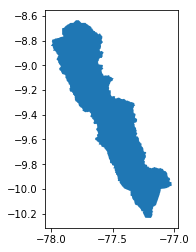

In [8]:
sdf.plot()

In [6]:
sdf

,COUNT,FLAECHE,RIOSAN,max_x,max_y,min_x,min_y,geometry
0,113.0,4.421497e+09,1,-77.020021,-8.633822,-77.998542,-10.235552,"POLYGON ((-77.90790 -8.72631, -77.90828 -8.725..."


In [10]:
file = cnst.GRIDSAT_PERU + 'daily_LT/gridsat_WA_-40Min_5000km2_13-19UTCperDay_*.nc'

In [11]:

dat = xr.open_mfdataset(file, combine='nested', concat_dim='time')
#dat = dat.resample(time="1D").min()
dat = dat['tir'].sel(lon=slice(gbox[0], gbox[1]), lat=slice(gbox[2],gbox[3]))/100
gmask = dat[0].salem.roi(shape=sdf)*0+1

OSError: no files to open

In [12]:
gbox = bigbox
isbuffer = gbox#smallbuffer

In [13]:
topo = xr.open_dataarray(cnst.TOPO_1MIN)
topo = topo.sel(lon=slice(isbuffer[0], isbuffer[1]), lat=slice(isbuffer[2], isbuffer[3]))

In [8]:
chirps = xr.open_dataset(cnst.elements_drive + 'SouthAmerica/CHIRPS/chirps-v2.0.daily.peru.nc').chunk({'time':365})
#chirpsm = xr.open_dataset(cnst.elements_drive + 'SouthAmerica/CHIRPS/chirps-v2.0.monthly.nc')
chirps = chirps['precip'].sel(longitude=slice(bigbox[0], bigbox[1]), latitude=slice(bigbox[2], bigbox[3]))

In [15]:
cmean = chirps.resample(time='M').sum().groupby('time.month').mean(['time']).compute()

(array([2.83251e+05, 1.15395e+05, 7.42020e+04, 6.70720e+04, 2.24050e+04,
        4.80600e+03, 1.90400e+03, 8.52000e+02, 2.91000e+02, 6.20000e+01]),
 array([  0.     ,  74.33774, 148.67548, 223.01321, 297.35095, 371.6887 ,
        446.02643, 520.36414, 594.7019 , 669.0397 , 743.3774 ],
       dtype=float32),
 <a list of 10 Patch objects>)

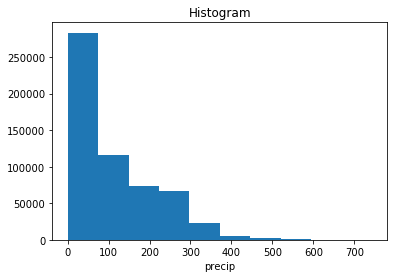

In [16]:
cmean.plot()

In [31]:
amazon = chirps.sel(latitude=slice(-9,-8), longitude=slice(-72.6, -71.6)).mean(dim=['longitude', 'latitude']).compute()
amazon = amazon.rolling(time=30, min_periods=1, center=True).mean(dim='time').groupby(chirps['time.dayofyear']).mean().sel(dayofyear=slice(1, 365))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Reductions will be applied along the rolling dimension 'time'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  


In [32]:
huaraz = chirps.salem.roi(shape=sdf).mean(dim=['longitude', 'latitude']).compute()
huaraz = huaraz.rolling(time=30, min_periods=1, center=True).mean(dim='time').groupby(chirps['time.dayofyear']).mean().sel(dayofyear=slice(1, 365))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Reductions will be applied along the rolling dimension 'time'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  


In [33]:
altiplano = chirps.sel(latitude=slice(-15,-14), longitude=slice(-72.6, -71.6)).mean(dim=['longitude', 'latitude']).compute()
altiplano = altiplano.rolling(time=30, min_periods=1, center=True).mean(dim='time').groupby(chirps['time.dayofyear']).mean().sel(dayofyear=slice(1, 365))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Reductions will be applied along the rolling dimension 'time'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  


In [34]:
alti_flat = chirps.sel(latitude=slice(-12,-11), longitude=slice(-71, -70)).mean(dim=['longitude', 'latitude']).compute()
alti_flat = alti_flat.rolling(time=30, min_periods=1, center=True).mean(dim='time').groupby(chirps['time.dayofyear']).mean().sel(dayofyear=slice(1, 365))

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Reductions will be applied along the rolling dimension 'time'. Passing the 'dim' kwarg to reduction operations has no effect and will raise an error in xarray 0.16.0.
  


In [35]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [36]:
huaraz.dayofyear

<xarray.DataArray 'dayofyear' (dayofyear: 365)>
array([  1,   2,   3, ..., 363, 364, 365])
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365

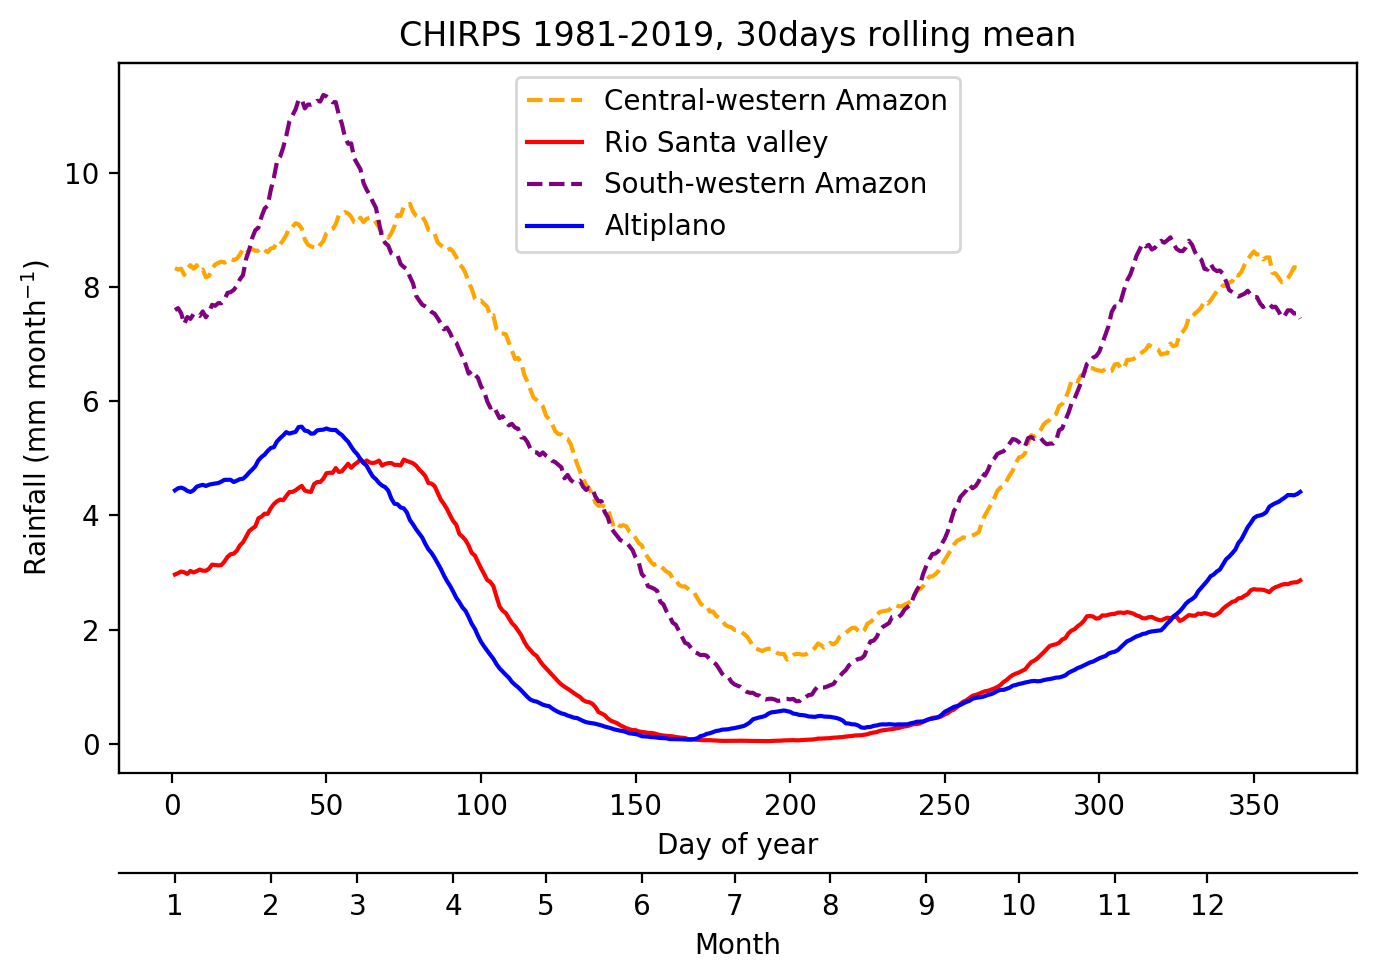

In [39]:
f = plt.figure(figsize=(7,5), dpi=200)
ax = f.add_subplot(111)
ax.plot(huaraz.dayofyear, amazon, label='Central-western Amazon', linestyle='dashed', color='orange')
ax.plot(huaraz.dayofyear, huaraz, label='Rio Santa valley', color='red')
ax.plot(huaraz.dayofyear, alti_flat, label='South-western Amazon', linestyle='dashed', color='purple')
ax.plot(huaraz.dayofyear, altiplano, label='Altiplano',  color='blue')
ax.set_title('CHIRPS 1981-2019, 30days rolling mean')

ax1.set_xlabel('Month')

mdays = [1,32,60,91,121,152,182,213,244,274,305,335]
ax1 = ax.twiny()
ax1.set_xticks(mdays)
ax1.set_xticklabels(np.arange(1,13))

ax1.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax1.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax1.spines['bottom'].set_position(('outward', 36))
ax1.set_xlabel('Month')
ax1.set_xlim(ax.get_xlim())

ax.set_xlabel('Day of year')
ax.set_ylabel('Rainfall (mm month$^{-1}$)')
ax.legend()
plt.tight_layout()
plt.savefig(fpath+'chirps_seasonal_cycle_doy.png')

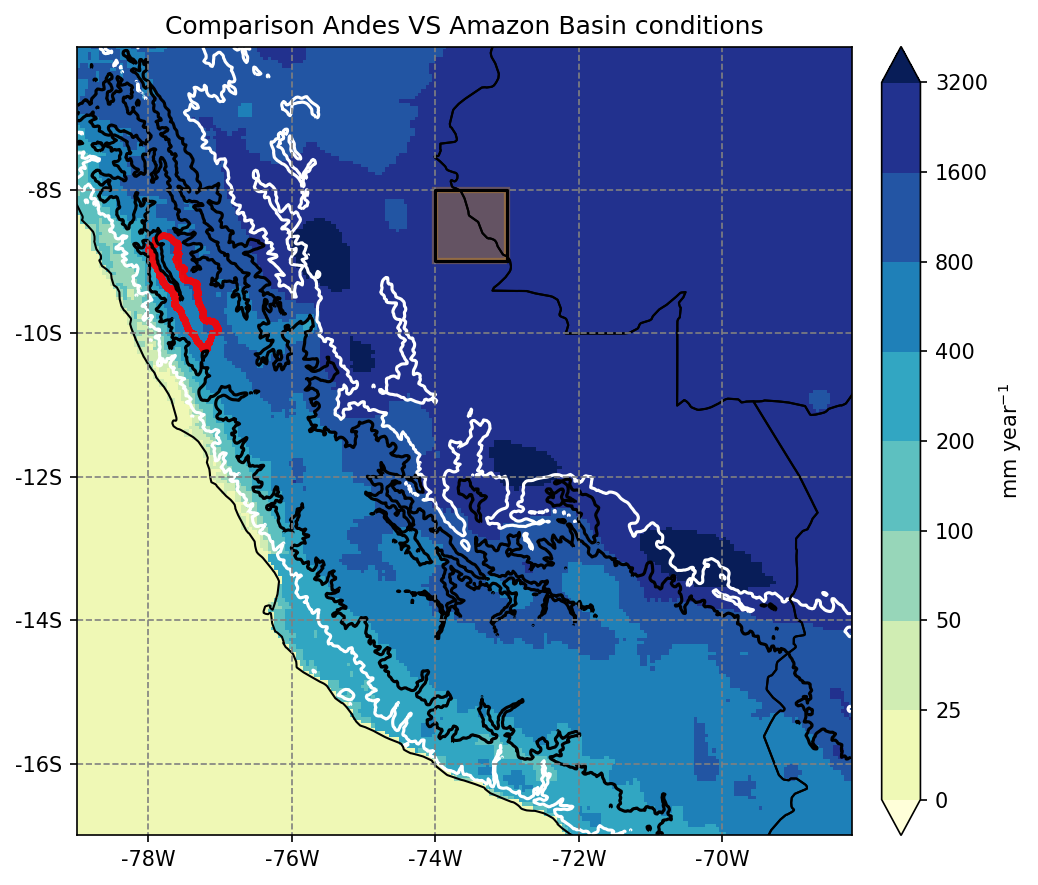

In [21]:
map = chirps.salem.get_map()
plt.figure(figsize=(7,6), dpi=150)
map.set_shapefile(sdf, color='red', linewidths=3,  alpha=0.9) #facecolor='red',
amazon = shpg.box(-74, -9, -73, -8)   #coord = [18, 25, -28, -20]
map.set_plot_params(levels=[0,25,50,100,200,400,800,1600,3200], cmap='YlGnBu', extend='both')
altip = shpg.box(-72.6, -15.5, -71.6, -14.5)   #coord = [18, 25, -28, -20]
altif = shpg.box(-71, -12, -70, -11)   #coord = [18, 25, -28, -20]
#map.set_geometry()
map.set_geometry(amazon,color='orange',linewidth=3, alpha=0.3, facecolor=None, linestyle='solid')
#map.set_geometry(altip,  color='blue', linewidth=3,  alpha=0.3, facecolor=None, linestyle='solid')
#map.set_geometry(altif,  color='purple', linewidth=3,  alpha=0.3, facecolor=None, linestyle='solid')
map.set_data(cmean.sum('month'))
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='mm year$^{-1}$', title='Comparison Andes VS Amazon Basin conditions')
plt.tight_layout()
plt.savefig(fpath+'chirps_boxregions_noAlti.png')

In [166]:
import shapely.geometry as shpg
topo = xr.open_dataarray(cnst.TOPO_1MIN)
topo =  topo.sel(lon=slice(bigbox[0], bigbox[1]), lat=slice(bigbox[2], bigbox[3]))

/home/ck/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


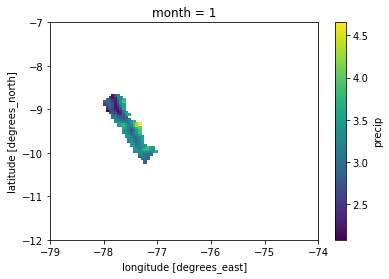

In [42]:
huaraz[0].plot()

In [15]:
wet_tab = pd.read_csv('/home/ck/DIR/cornkle/data/HUARAZ/dry_wet_schlump/wet_gl_sp.csv', names=['date','tag'])
dry_tab = pd.read_csv('/home/ck/DIR/cornkle/data/HUARAZ/dry_wet_schlump/dry_gl_sp.csv', names=['date','tag'])

In [16]:
wet_tab = wet_tab[wet_tab['tag']==1]
dry_tab = dry_tab[dry_tab['tag']==1]

In [17]:
wet_tab = wet_tab[wet_tab['date']>'1984-12-31']
dry_tab = dry_tab[dry_tab['date']>'1984-12-31']

In [22]:
wet_tab

,date,tag
681,1985-02-13,1.0
682,1985-02-14,1.0
683,1985-02-15,1.0
688,1985-02-20,1.0
689,1985-02-21,1.0
...,...,...
4458,2016-03-03,1.0
4459,2016-03-04,1.0
4460,2016-03-05,1.0
4461,2016-03-06,1.0


In [23]:
tab = wet_tab[400:430]

In [27]:
def run(shift):
    dic = {
    'q200' : [],
    'q550' : [],
    'q850' : [],
    't' : [],
    'u200' : [],
    'v200' : [],
    'u550' : [],
    'v550' : [],
    'u850' : [],
    'v850' : [],
    'u200_orig' : [],
    'v200_orig' : [],
    'u550_orig' : [],
    'v550_orig' : [],
    'u850_orig' : [],
    'v850_orig' : [],
    'w550' : [],    
    'd' : [],
    't2' : [],
    'slp' : [],
    'cnt' : [],
    'cape' : [],
    'divMoist' : [],
    'sh' : [],
    'rh' : [],
    'zshear' : [],
    'theta' : [],
    'tcwv' : []    
    }

    bigbox = [-79,-65,-17,-3]
    for date in tab.date:


        single = tab[tab.date==date]

        dt = pd.to_datetime(date)
        daystring = str(abs(shift))
        dayd = pd.Timedelta(daystring + 'days')
        if shift < 0:
            dt = dt - dayd
        if shift >=0:
            dt = dt + dayd
            
        window1 = dt - pd.Timedelta('10days')
        window2 = dt + pd.Timedelta('10days')
        

        fdate = '_' + str(dt.year) +'_' + str(dt.month).zfill(2) + '_'# + str(dt.day).zfill(2)
        
        hour = 15
        shour = 15

        try:
            era5_files = '/media/ck/Elements/SouthAmerica/ERA5/hourly/' #cnst.ERA5 + 'hourly/
            lsta = xr.open_dataset(era5_files + 'pressure_levels/ERA5' + fdate + 'pl.nc') #sma  #'AMSR_L3_LPRMv05_A_'
#             lsta_clim = xr.open_dataset(clim + \
#                             'pressure_levels/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_pl.nc')
            
            srfc = xr.open_dataset(era5_files + 'surface/ERA5' + fdate + 'srfc.nc') #sma  #'AMSR_L3_LPRMv05_A_'
#             srfc_clim = xr.open_dataset(clim + \
#                             'surface/ERA5_2000-2014_CLIM_' + str(dt.month).zfill(2) + '-'+str(hour).zfill(2)+'_srfc.nc')

        except:
            print('File missing', cnst.ERA5  + 'hourly/pressure_levels/ERA5' + fdate + 'pl.nc')
            continue
            
        lsta = u_darrays.flip_lat(lsta)
        srfc = u_darrays.flip_lat(srfc)
        

        lsta = lsta.sel(longitude=slice(bigbox[0], bigbox[1]), latitude=slice(bigbox[2],bigbox[3]))
        #lsta_clim = lsta_clim.sel(lon=slice(-18, -5), lat=slice(9, 17))
        
        srfc = srfc.sel(longitude=slice(bigbox[0], bigbox[1]), latitude=slice(bigbox[2],bigbox[3]))
        #srfc_clim = srfc_clim.sel(lon=slice(-18, -5), lat=slice(9, 17))
        
        pos = np.where(lsta['time.hour']==shour)
        if np.sum(pos) == 0:
            continue
        
        try:
            lsta_low = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=550)
        except:
            continue
        lsta_up = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=200)
        lsta_bot = lsta.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00', level=850)
        
        srfc_low = srfc.sel(time=str(dt.year)+'-'+str(dt.month)+'-'+str(dt.day)+'T'+str(hour).zfill(2)+':00:00')
        
        lsta10 = lsta.isel(time=pos[0])
        lsta10_bot = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=850)
        
        
        lsta10_low = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=550)
        
        lsta10_up = lsta10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'), level=200)
             
        
        pos = np.where(srfc['time.hour']==shour)
        #ipdb.set_trace()
        srfc10 = srfc.isel(time=pos[0])
        srfc10 = srfc10.sel(time=slice(str(window1.year)+'-'+str(window1.month)+'-'+str(window1.day)+'T'+str(shour).zfill(2)+':00:00' , \
                                      str(window2.year)+'-'+str(window2.month)+'-'+str(window2.day)+'T'+str(shour).zfill(2)+':00:00'))
     

        q = lsta_low['q'].squeeze()
        qbot = lsta_bot['q'].squeeze()
        qup = lsta_up['q'].squeeze()
        uup = lsta_up['u'].squeeze()
        vup = lsta_up['v'].squeeze()
        ulow = lsta_low['u'].squeeze()
        vlow = lsta_low['v'].squeeze()
        ubot = lsta_bot['u'].squeeze()
        vbot = lsta_bot['v'].squeeze()
        wlow = lsta_low['w'].squeeze()
        t = lsta_low['t'].squeeze()
        d = lsta_low['d'].squeeze()
        rh = lsta_low['r'].squeeze()
        t2 = srfc_low['t2m'].squeeze()
        slp = srfc_low['sp'].squeeze()
        cape = srfc_low['cape'].squeeze()
        cin = srfc_low['cin'].squeeze()
        divMoist = srfc_low['p84.162'].squeeze()
        sh = srfc_low['msshf'].squeeze()
        tcwv = srfc_low['tcwv'].squeeze()
        
        q_clim = lsta10_low['q'].squeeze().mean('time')
        qbot_clim = lsta10_bot['q'].squeeze().mean('time')
        qup_clim = lsta10_up['q'].squeeze().mean('time')
        uup_clim = lsta10_up['u'].squeeze().mean('time')
        vup_clim = lsta10_up['v'].squeeze().mean('time')
        ulow_clim = lsta10_low['u'].squeeze()
        vlow_clim = lsta10_low['v'].squeeze()
        ubot_clim = lsta10_bot['u'].squeeze()
        vbot_clim = lsta10_bot['v'].squeeze()
        w_clim = lsta10_low['w'].squeeze().mean('time')
        t_clim = lsta10_low['t'].squeeze().mean('time')
        rh_clim = lsta10_low['r'].squeeze().mean('time')
        d_clim = lsta10_low['d'].squeeze().mean('time')
        t2_clim = srfc10['t2m'].squeeze().mean('time')
        slp_clim = srfc10['sp'].squeeze().mean('time')
        cin_clim = srfc10['cin'].squeeze().mean('time')
        divMoist_clim = srfc10['p84.162'].squeeze().mean('time')
        sh_clim = srfc10['msshf'].squeeze().mean('time')
        tcwv_clim = srfc10['tcwv'].squeeze()
        

        print('Doing '+ 'AMSR_' + str(dt.year) + str(dt.month).zfill(2) + str(
        dt.day).zfill(2) + '.nc')
    
        theta_low = u_met.theta_e(550,lsta_low['t'].squeeze().values-273.15,lsta_low['q'].squeeze().values)
        
        punit = units.Quantity(200, 'hPa')
        tunit = units.Quantity(lsta_up['t'].squeeze().values-273.15, 'K')
        theta_high = calc.saturation_equivalent_potential_temperature(punit,tunit)

        thetadiff = (theta_low-theta_high).squeeze()
        
        theta10_low = u_met.theta_e(550,lsta10_low['t'].squeeze().mean('time').values-273.15,lsta10_low['q'].squeeze().mean('time').values)
        
        tunit = units.Quantity(lsta10_up['t'].squeeze().mean('time').values-273.15, 'K')
        theta10_high = calc.saturation_equivalent_potential_temperature(punit,tunit)
        thetadiff10 = (theta10_low-theta10_high).squeeze()
        
        cnt = np.zeros_like(q.values)
        cnt[np.isfinite(q.values)] = 1

        dic['q550'].append(q.values- q_clim.values)
        dic['q850'].append(qbot.values- qbot_clim.values)
        dic['q200'].append(qup.values- qup_clim.values)
        dic['v200'].append(vup.values- vup_clim.values)
        dic['u200'].append(uup.values- uup_clim.values)
        dic['v550'].append(vlow.values- vlow_clim.values)
        dic['u550'].append(ulow.values- ulow_clim.values)
        dic['v850'].append(vbot.values- vbot_clim.values)
        dic['u850'].append(ubot.values- ubot_clim.values)
        dic['v200_orig'].append(vup.values)#
        dic['u200_orig'].append(uup.values)#
        dic['v550_orig'].append(vlow.values)#
        dic['u550_orig'].append(ulow.values)#
        dic['v850_orig'].append(vbot.values)#
        dic['u850_orig'].append(ubot.values)#
        dic['w550'].append(wlow.values- wlow_clim.values)
        dic['rh'].append(rh.values- rh_clim.values)
        dic['t'].append(t.values-t_clim.values)
        dic['d'].append(d.values-d_clim.values)
        dic['t2'].append(t2.values-t2_clim.values)
        dic['slp'].append(slp.values-slp_clim.values)
        dic['cape'].append(cape.values-cape_clim.values)#s-v100_clim.values)
        dic['divMoist'].append(divMoist.values-divMoist_clim.values)#-slp_clim.values)
        dic['sh'].append(sh.values-sh_clim.values)
        ws, wd = u_met.u_v_to_ws_wd(uup.values-ulow.values, vup.values-vlow.values)
        wsclim, wd = u_met.u_v_to_ws_wd(uup_clim.values-ulow_clim.values, vup_clim.values-vlow_clim.values)
        dic['zshear'].append(ws-wsclim) #-wsclim
        dic['theta'].append(thetadiff-thetadiff10)
        dic['tcwv'].append(tcwv.values-tcwv_clim.values)
        dic['cnt'].append(cnt)

        lat = lsta_low.latitude.values
        lon = lsta_low.longitude.values
        
        del lsta
        del srfc
        
    #ipdb.set_trace()
    for k in dic.keys():
        #print(k)
        dic[k] = np.nansum(np.stack(dic[k], axis=0), axis=0)

    return dic, lat, lon

In [25]:
def calc(dic):
    
    dics = {}
    for k in dic.keys():
        if k == 'cnt':
            continue
        dics[k] = dic[k] / dic['cnt']
    return dics

In [26]:
dic, lat, lon = run(0)

AttributeError: 'DataFrame' object has no attribute 'time'